In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Load datasets
def load_np_array(file_name):
    X_array = np.load('data/X_' + file_name + '_array.npy')
    y_array = np.load('data/y_' + file_name + '_array.npy')
    return X_array, y_array

X_train_fall, y_train_fall = load_np_array("train_fall")
X_train_notfall, y_train_notfall = load_np_array("train_notfall")
X_test_fall, y_test_fall = load_np_array("test_fall")
X_test_notfall, y_test_notfall = load_np_array("test_notfall")

# Combine fall and not-fall data
X_train = np.concatenate((X_train_fall, X_train_notfall), axis=0)
y_train = np.concatenate((y_train_fall, y_train_notfall), axis=0)
X_test = np.concatenate((X_test_fall, X_test_notfall), axis=0)
y_test = np.concatenate((y_test_fall, y_test_notfall), axis=0)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




In [2]:
# Define the LSTM model
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0, c0 = self.init_hidden(x)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(self.relu(out[:, -1]))
        return out

    def init_hidden(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return h0, c0

In [5]:


# Initialize model, criterion, and optimizer
input_dim = X_train_tensor.shape[2]  # Number of features
hidden_dim = 64
output_dim = 1  # Binary classification
n_layers = 1
model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Trackers for losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 10  # Adjust number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.float(), y_batch.float()
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = torch.round(torch.sigmoid(output.squeeze()))
        total_train += y_batch.size(0)
        correct_train += (predicted == y_batch).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

 # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.float(), y_batch.float()
            output = model(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            
            val_loss += loss.item()
            predicted = torch.round(torch.sigmoid(output.squeeze()))
            total_val += y_batch.size(0)
            correct_val += (predicted == y_batch).sum().item()
            
            all_preds.extend(predicted.numpy())
            all_labels.extend(y_batch.numpy())
    
    val_losses.append(val_loss / len(test_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracy * 100:.2f}%')


Epoch [1/10] - Train Loss: 0.5660, Train Accuracy: 71.84%, Val Loss: 0.5056, Val Accuracy: 77.95%
Epoch [2/10] - Train Loss: 0.3198, Train Accuracy: 88.02%, Val Loss: 0.2786, Val Accuracy: 87.12%
Epoch [3/10] - Train Loss: 0.1944, Train Accuracy: 93.60%, Val Loss: 0.1530, Val Accuracy: 94.06%
Epoch [4/10] - Train Loss: 0.1646, Train Accuracy: 94.27%, Val Loss: 0.1700, Val Accuracy: 92.89%
Epoch [5/10] - Train Loss: 0.1466, Train Accuracy: 94.99%, Val Loss: 0.1236, Val Accuracy: 94.57%
Epoch [6/10] - Train Loss: 0.1754, Train Accuracy: 94.02%, Val Loss: 0.1293, Val Accuracy: 95.09%
Epoch [7/10] - Train Loss: 0.1149, Train Accuracy: 96.05%, Val Loss: 0.1436, Val Accuracy: 94.02%
Epoch [8/10] - Train Loss: 0.1213, Train Accuracy: 95.98%, Val Loss: 0.1164, Val Accuracy: 95.57%
Epoch [9/10] - Train Loss: 0.0994, Train Accuracy: 96.82%, Val Loss: 0.1162, Val Accuracy: 95.36%
Epoch [10/10] - Train Loss: 0.0932, Train Accuracy: 96.84%, Val Loss: 0.1552, Val Accuracy: 94.64%


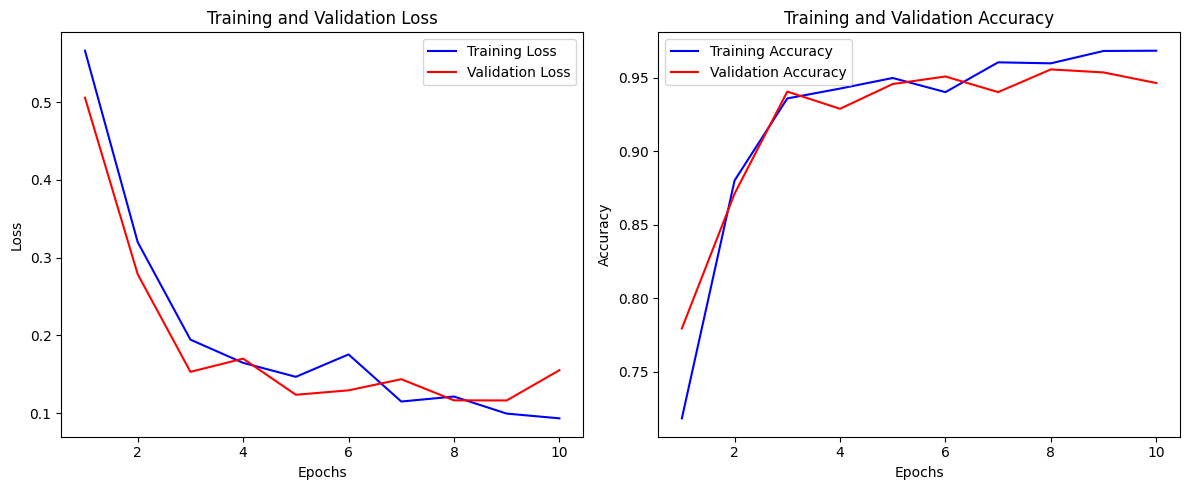

Accuracy: 0.9464285714285714
Precision: 0.9616477272727273
Recall: 0.929945054945055
F1 Score: 0.9455307262569832
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.96      0.95      1456
         1.0       0.96      0.93      0.95      1456

    accuracy                           0.95      2912
   macro avg       0.95      0.95      0.95      2912
weighted avg       0.95      0.95      0.95      2912



In [6]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# Metrics on the final validation set
y_test_pred = np.array(all_preds)
y_test_true = np.array(all_labels)

print("Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("Precision:", precision_score(y_test_true, y_test_pred, zero_division=0))
print("Recall:", recall_score(y_test_true, y_test_pred, zero_division=0))
print("F1 Score:", f1_score(y_test_true, y_test_pred, zero_division=0))
print("Classification Report:\n", classification_report(y_test_true, y_test_pred, zero_division=0))
